<a href="https://colab.research.google.com/github/MekdiYilma/HumanitarianCrisisPrediction/blob/main/notebooks/RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%%bigquery --project asana-bq yemen_df
SELECT SQLDATE, Actor1Name, Actor2Name, QuadClass, GoldsteinScale, NumArticles, AvgTone, EventCode
FROM `gdelt-bq.gdeltv2.events` 
WHERE ActionGeo_CountryCode = 'YM'
ORDER BY SQLDATE DESC 
LIMIT 20000

In [4]:
humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                              '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                              '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                              '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                              '1833', '184']
yemen_df['IsHumanitarianCrisis'] = yemen_df.EventCode.isin(humanitarian_crisis_events)
yemen_df.SQLDATE = pd.to_datetime(yemen_df.SQLDATE, format='%Y%m%d', errors='ignore')
yemen_df = yemen_df.set_index('SQLDATE')
yemen_df_grouped = yemen_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq='d')).agg(['sum','count','mean'])
yemen_df_grouped

,sum,count,mean
SQLDATE,,,
2021-05-05,1,49,0.020408
2021-05-06,8,430,0.018605
2021-05-07,18,476,0.037815
2021-05-08,19,334,0.056886
2021-05-09,18,308,0.058442
...,...,...,...
2021-07-09,10,224,0.044643
2021-07-10,9,214,0.042056
2021-07-11,4,181,0.022099


In [7]:
yemen_df_ts = yemen_df_grouped[['mean']]
yemen_df_ts

,mean
SQLDATE,
2021-05-05,0.020408
2021-05-06,0.018605
2021-05-07,0.037815
2021-05-08,0.056886
2021-05-09,0.058442
...,...
2021-07-09,0.044643
2021-07-10,0.042056
2021-07-11,0.022099


In [12]:
idx = int(len(yemen_df_ts)*0.75)
yemen_df_train =  yemen_df_ts.iloc[:idx]
yemen_df_test =  yemen_df_ts.iloc[idx:]
 

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(yemen_df_train)
scaled_train = scaler.transform(yemen_df_train)
scaled_test = scaler.transform(yemen_df_test)

In [17]:
scaled_train[:10]

array([[0.21535983],
       [0.19632803],
       [0.39904909],
       [0.6002994 ],
       [0.61671224],
       [0.53710999],
       [0.69833591],
       [0.57650956],
       [0.14968272],
       [0.80730515]])

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [68]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [69]:
X, y = generator[1]
print(f'Given an array X: {X.flatten()}')
print(f'predict this y: {y}')

Given an array X: [0.19632803 0.39904909 0.6002994  0.61671224 0.53710999 0.69833591
 0.57650956 0.14968272 0.80730515 0.06988498 0.41382869 0.2524553 ]
predict this y: [[0.42780939]]


In [70]:
X.shape

(1, 12, 1)

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [72]:
model = Sequential()
model.add(LSTM(units=4, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [73]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(generator, epochs=10)

Epoch 1/10
40/40 [==============================] - 2s 4ms/step - loss: 0.0485
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0473
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0542
Epoch 4/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 5/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 6/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0739
Epoch 7/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0505
Epoch 8/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0366
Epoch 9/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0517
Epoch 10/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0560


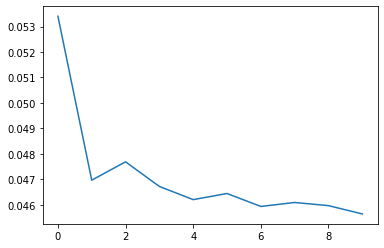

In [75]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [76]:
last_train_batch = scaled_train[-n_input:]

In [77]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [78]:
model.predict(last_train_batch)

array([[0.39869025]], dtype=float32)

In [79]:
scaled_test[0]

array([0.17299396])

In [80]:
test_predictions  = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(yemen_df_test)):
  # get the predictiion value for the first batch
  current_pred = model.predict(current_batch)[0]

  # append the prediction into an array
  test_predictions.append(current_pred)

  # use prediction to update the batch and remove the first value
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [81]:
test_predictions

[array([0.39869025], dtype=float32),
 array([0.40594938], dtype=float32),
 array([0.40989694], dtype=float32),
 array([0.4098932], dtype=float32),
 array([0.3972703], dtype=float32),
 array([0.3913048], dtype=float32),
 array([0.39678776], dtype=float32),
 array([0.3927419], dtype=float32),
 array([0.38674578], dtype=float32),
 array([0.3870269], dtype=float32),
 array([0.3918182], dtype=float32),
 array([0.38809708], dtype=float32),
 array([0.3806299], dtype=float32),
 array([0.3784054], dtype=float32),
 array([0.37564224], dtype=float32),
 array([0.37264964], dtype=float32),
 array([0.36956474], dtype=float32),
 array([0.36675522], dtype=float32)]

In [82]:
true_predictions = scaler.inverse_transform(test_predictions)

In [83]:
yemen_df_test['predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


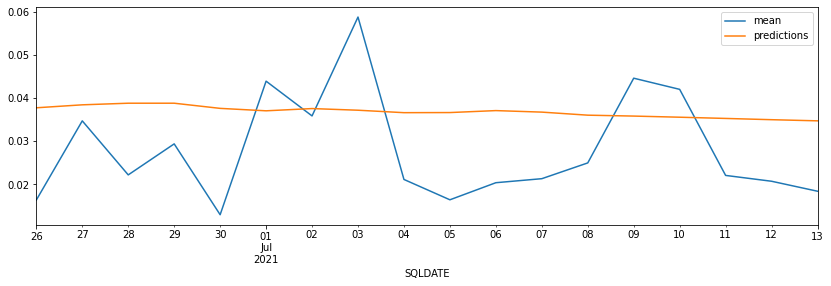

In [84]:
yemen_df_test.plot(figsize=(14,4))

In [85]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(yemen_df_test['mean'], yemen_df_test['predictions']))

0.01493427988878323